# House Prices
This is my work based on the housing prices competition on kaggle https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [2]:
import pandas as pd

test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Missing Data
First I will look at the number of missing values in each column and the percentage of values that are missing

In [3]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


As a number of them have significant numbers of missing values, I will remove these variables. I have defined that above 15% is a good value to remove from. To deal with the observations for electrical, MassVnrType and Area I will first plot these variables to see if the mean makes sense to use as a replacement. I will also plot a correlation plot to see if missing variables can be described by others.

In [4]:
train.drop(["Id"], axis = 1, inplace = True)
test.drop(["Id"], axis = 1, inplace = True)

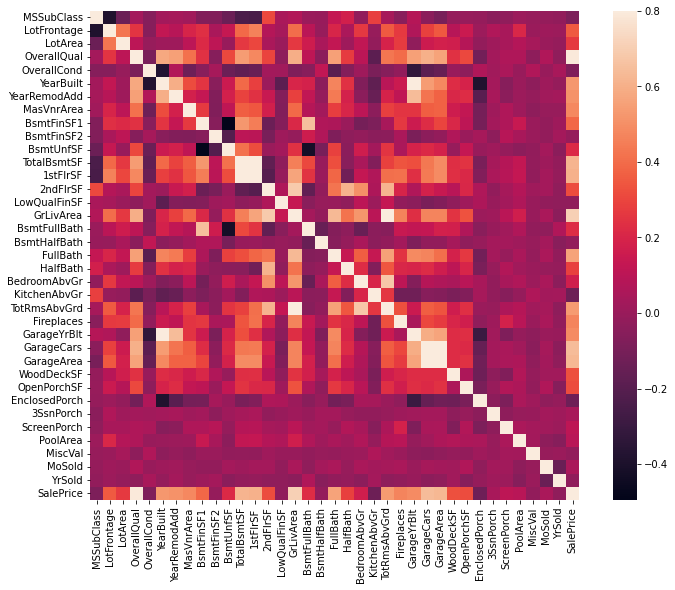

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = train.corr()
fig, ax = plt.subplots(figsize=(12,9))     
sns.heatmap(corr, vmax=.8, square=True);

In [6]:
miss=train[["GarageYrBlt",
"GarageCond",
"GarageType",
"GarageFinish",
"GarageQual",
"BsmtFinType2",
"BsmtExposure",
"BsmtQual",
"BsmtCond",
"BsmtFinType1"]]
miss.head()

,GarageYrBlt,GarageCond,GarageType,GarageFinish,GarageQual,BsmtFinType2,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1
0,2003.0,TA,Attchd,RFn,TA,Unf,No,Gd,TA,GLQ
1,1976.0,TA,Attchd,RFn,TA,Unf,Gd,Gd,TA,ALQ
2,2001.0,TA,Attchd,RFn,TA,Unf,Mn,Gd,TA,GLQ
3,1998.0,TA,Detchd,Unf,TA,Unf,No,TA,Gd,ALQ
4,2000.0,TA,Attchd,RFn,TA,Unf,Av,Gd,TA,GLQ


As there is no way of finding these missing values and that these are not the most import features for prediction we will drop these columns. Also should be noted that garage year built is very strongly correlated to house build year.

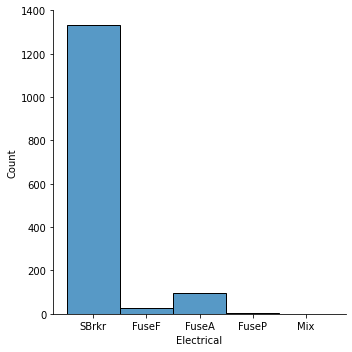

In [7]:
sns.displot(train['Electrical']);

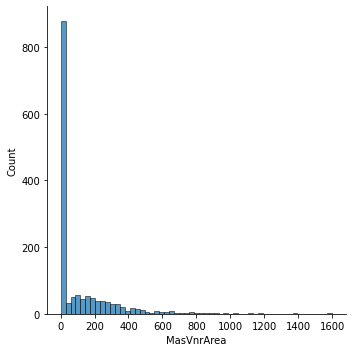

In [8]:
sns.displot(train['MasVnrArea']);

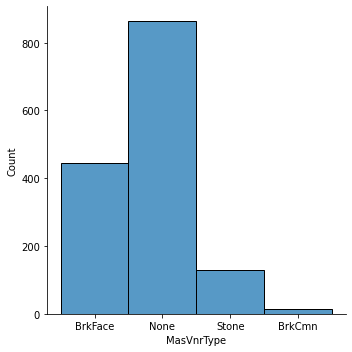

In [9]:
sns.displot(train['MasVnrType']);

Masonry veneer and MasVnrArea: Masonry veneer are not important features and are impossible to get replace the variable, this is because it is categorical for one while the area there is a large peak around 0. These will be removed, the 1 entry for electrical will also be removed because again it cant be replaced.

In [10]:
train.drop((missing_data[missing_data['Total'] > 1]).index,1, inplace = True)
train.drop(train.loc[train['Electrical'].isnull()].index, inplace = True)

C:\Users\Andrew\AppData\Local\Temp/ipykernel_13868/1459822559.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train.drop((missing_data[missing_data['Total'] > 1]).index,1, inplace = True)


## Data Visulization
First we need to look at sale price as this is what we are trying to predict.

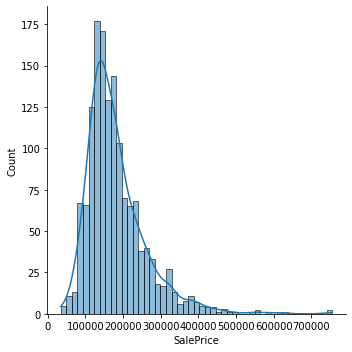

In [11]:
sns.displot(train['SalePrice'],kde=True)

This plot is right skewed (which you can measure). As we know that machine learning algorithms prefer normally distributed values this will need to transformed by taking the log.

In [12]:
import numpy as np
train["SalePrice"] = np.log1p(train["SalePrice"])

## Preparing data for Machine learning
We need to prepare the data for use in the machine learning models. First we need to split the data into a test and train set. I will then use a pipeline to transform all the data in a efficient way. For the numerical data I will just use Standard Scalar, this will scale all the values to be in the same range. This is useful for instance if we where comparing age (0-100) and wage (0-100000) these would have a different effect due to the different ranges of values. The ordinal encoder will change all the categorical variables into numbers so they can be used in the machine learning algorithm.

In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(train,test_size=0.2)
train_y=train_set["SalePrice"]
train_x=train_set.drop(["SalePrice"], axis=1)
test_y=test_set["SalePrice"]
test_x=test_set.drop(["SalePrice"], axis=1)

In [14]:
train_set_num=train_x.select_dtypes(include=[np.number])
train_set_ob=train_x.select_dtypes(include=[object])
num_column=list(train_set_num.columns)
ob_column=list(train_set_ob.columns)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_column),
        ("cat", OrdinalEncoder(), ob_column),
    ])

train_prepared = full_pipeline.fit_transform(train_x)
test_x = full_pipeline.fit_transform(test_x)

## Machine Learning Models
Now that is ready I will start building the models and uses cross_val_score to be able to find the root mean square error. 

In [22]:
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

In [31]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

def eval(model,test_x,test_y):
    ymul=model.predict(test_x)
    print("Model score: %.4f" % model.score(test_x,test_y))  # This is just shorthand for the R2 score
    print("Mean absolute error: %.4f" % mean_squared_error(ymul,test_y))
    print("R2-score: %.4f" % r2_score(test_y , ymul) )
    score=np.sqrt(-cross_val_score(model, train_prepared, train_y, scoring="neg_mean_squared_error", cv = 10))
    print("RMSE score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

#### Evaluation Scores
* Mean Absolute Error: It is the mean of the absolute value of the errors. This is the easiest of the metrics to understand since it’s just average error.
* Mean Squared Error (MSE): Mean Squared Error (MSE) is the mean of the squared error. It’s more popular than Mean Absolute Error because the focus is geared more towards large errors. This is due to the squared term exponentially increasing larger errors in comparison to smaller ones.
* Root Mean Squared Error (RMSE). RMSD is the square root of the average of squared errors. The effect of each error on RMSD is proportional to the size of the squared error; thus larger errors have a disproportionately large effect on RMSD. Consequently, RMSD is sensitive to outliers
* R-squared is not an error, but rather a popular metric to measure the performance of your regression model. It represents how close the data points are to the fitted regression line. The higher the R-squared value, the better the model fits your data. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

### Linear Regression based models

When trying to fit a LinearRegression model you are trying to minise the cost function which is the mean square error. There are 2 main ways of doing this mathmatically. These are the normal equation and Singular Value Decompostion, with the implementation in sklearn using SVD. These however have the problem that they scale porely with large data sets. 

In [24]:
lin_reg=LinearRegression()
lin_reg.fit(train_prepared,train_y)
eval(lin_reg,test_x,test_y)

Model score: -91624726012244539736064.00
Mean absolute error: 91208199989.73
Residual sum of squares (MSE): 14830049213229899448320.00
R2-score: -91624726012244539736064.00
RMSE score: 25004361.5346 (75013084.1078)



When the data set is large you can train the model instead using gradient decent. The basic idea of this is to tweak the feature of the cost function iteratively to minimize the cost function. The anology that is often given is if you are on a mountian and trying to find the way down, you could look at the steepness of the slope and go where the steepness is greatest. The most important parameter of this method is the learning rate, this is because a small value will take a long time to converge to the correct value. While a large one the model would bounce around the optimal soluation making the model diverge. Another problem with this method is if the cost function is not a nice regular bowl. This could lead to the soluation actually being a local minumum rather than a global minumum. However this isnt a problem with the MSE cost function as it happens to be a convex function. This means that if you pick 2 point on the curve the line segment joining them would never cross the curve.                                           
If you use the whole training set for this then it is known as batch gradient decent, this however has the problem of taking a long time with large data sets. To try and solve this problem we can use Stochastic gradient descent. In this you pick a random instance from training set and calulate the gradiants based only on that instance. This increases the speed of the calculation as it only does it on a small amount of data. However due to the randomness of this procress the cost function will bounce around and will never settle at the global miniumum, this however can sometimes help if the cost function has local minimums it can bounce out of it. The method is impletmented in SGDRegressor.           
You can also have a mini-batch gradient decent, this computes of the cost function on a small random subset of the overall data.  

In [25]:
sgd_reg=SGDRegressor(max_iter=1000,tol=1e-3,penalty=None,eta0=0.1)
sgd_reg.fit(train_prepared,train_y)
eval(sgd_reg,test_x,test_y)

Model score: -4961167323682627819405312.00
Mean absolute error: 750067587426.50
Residual sum of squares (MSE): 802996732076984438358016.00
R2-score: -4961167323682627819405312.00
RMSE score: 1437236912206.0210 (668643042262.1066)



Sometimes when we make a model it will overfit the data. A good way to reduce this is to regularize the model (constrain it). For a linear model the normal way is to constrain the weights of the model. The first one I will try in this is ridge regression, in this a term is added to the cost function to keep the model weights as small as possible. They hyperparameters alpha controles how much you want this model to regularize, =0 is just linear regression and =1 means all the weights will be close to 0. 

In [26]:
ridge_reg=Ridge(alpha=1,solver="cholesky")
ridge_reg.fit(train_prepared,train_y)
eval(ridge_reg,test_x,test_y)

Model score: 0.91
Mean absolute error: 0.09
Residual sum of squares (MSE): 0.01
R2-score: 0.91
RMSE score: 0.1599 (0.0499)



Lasso regression is next and this has the characteristic that the least important feature weights tend towards 0, this allows for automatic feature selection which sometimes can be useful.

In [27]:
lasso_reg=Lasso(alpha =0.1, random_state=1)
lasso_reg.fit(train_prepared,train_y)
eval(lasso_reg,test_x,test_y)

Model score: 0.70
Mean absolute error: 0.17
Residual sum of squares (MSE): 0.05
R2-score: 0.70
RMSE score: 0.2231 (0.0232)



Elastic net is the middle ground between lasso and ridge. The l1_ratio defines the mixing between them (=1 is just lasso)

In [28]:
elastic_net = ElasticNet(alpha=0.1,l1_ratio=0.5)
elastic_net.fit(train_prepared,train_y)
eval(elastic_net,test_x,test_y)

Model score: 0.82
Mean absolute error: 0.13
Residual sum of squares (MSE): 0.03
R2-score: 0.82
RMSE score: 0.1875 (0.0310)



#### Optimizing the hyperparameters
As the regularized models have hyperparameters we need to choose them. Just based on knowledge we would probably get to the correct area of the model but they will never be perfect. Luckily sklearn has a built in method called GridSearchCV and RandomizedSeachCV that will allow you to find the correct values better. GridSearchCV takes a list of values for the hyperparameters you want to try while RandomizedSeachCV takes a range of values and the number of times to run to get the best soluation. The works very well with small numbers of hyperparamters.

##### Ridge Regression

In [34]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint

param_grid= {'alpha': randint(low=0.0, high=300.0), }
rnd_search = RandomizedSearchCV(ridge_reg, param_distributions=param_grid, n_iter=300, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(train_prepared, train_y)
print("RandomSearch best", rnd_search.best_estimator_)

param_grid = [ {'alpha': [0,11]}  ]
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(train_prepared, train_y)
print("GridSearch best", grid_search.best_estimator_)

RandomSearch best Ridge(alpha=251, solver='cholesky')
GridSearch best Ridge(alpha=11, solver='cholesky')


C:\Users\Andrew\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.09532e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [35]:
ridge_reg=Ridge(alpha=242,solver="cholesky")
ridge_reg.fit(train_prepared,train_y)
eval(ridge_reg,test_x,test_y)

Model score: 0.91
Mean absolute error: 0.01
R2-score: 0.91
RMSE score: 0.1558 (0.0472)



##### Lasso Regression

In [36]:
param_grid= {'alpha': randint(low=0.0005, high=100),}
rnd_search = RandomizedSearchCV(lasso_reg, param_distributions=param_grid,n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(train_prepared, train_y)
print("RandomSearch best", rnd_search.best_estimator_)

param_grid = [{'alpha': [0.0005,0.1,0.2,10,51]} ]
grid_search = GridSearchCV(lasso_reg, param_grid, cv=5,scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(train_prepared, train_y)
print("GridSearch best", grid_search.best_estimator_)

RandomSearch best Lasso(alpha=51, random_state=1)
GridSearch best Lasso(alpha=0.0005, random_state=1)


In [37]:
lasso_reg=Lasso(alpha =0.0005, random_state=1)
lasso_reg.fit(train_prepared,train_y)
eval(lasso_reg,test_x,test_y)

Model score: 0.91
Mean absolute error: 0.01
R2-score: 0.91
RMSE score: 0.1585 (0.0504)



##### Elastic Net Regression

In [38]:
param_grid= {'alpha': randint(low=0.1, high=1),'l1_ratio': randint(low=0.1, high=1)}
#rnd_search = RandomizedSearchCV(elastic_net, param_distributions=param_grid,n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
#rnd_search.fit(train_prepared, train_y)

param_grid = [{'alpha': [0.1,0.2],'l1_ratio': [0.1,0.5,0.9,1] } ]
grid_search = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(train_prepared, train_y)
print("GridSearch best", grid_search.best_estimator_)

GridSearch best ElasticNet(alpha=0.1, l1_ratio=0.1)


In [39]:
elastic_net = ElasticNet(alpha=0.1,l1_ratio=0.1)
elastic_net.fit(train_prepared,train_y)
eval(elastic_net,test_x,test_y)

Model score: 0.90
Mean absolute error: 0.02
R2-score: 0.90
RMSE score: 0.1583 (0.0438)



### Decsion tree based regression

A decision tree is normally used for classification but can also but done for regression. A decision tree works by asking a intial question at the root node for instance in this case is the sale condition normal and then depending on the answer you go down one of the nodes to another question if needed (for simple datasets it may not be needed to be able to divide the data up). You measure the impurity of the node called gini, if the node is complety pure then it would =0. In skearn it uses the CART algorithm, this works by splitting the data set into 2 subsets using a single feature and a threshold, it then continues to do this until the max depth is reached or a split will not reduce the impurity. To use this for regression it is very similar, however instead of predicting a class to assign to it predicts a value. You have to be careful though as not setting a maximum depth would normally result in overfitting.

In [41]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=5)
tree_reg.fit(train_prepared,train_y)
eval(tree_reg,test_x,test_y)

Model score: 0.72
Mean absolute error: 0.04
R2-score: 0.72
RMSE score: 0.2055 (0.0337)



### Ensemble Learning

#### Bagging

A random forest algorthim is a ensemble of decesion trees trained using the bagging method. This involves using the same algorithm and training them on a subets of the training data, once this is done the ensemble makes predictions by agregating the result (most frequent for classification and average for regression).  

In [52]:
from sklearn.ensemble import RandomForestRegressor

rmdtree_reg = RandomForestRegressor(max_depth=5)
rmdtree_reg.fit(train_prepared,train_y)
eval(rmdtree_reg,test_x,test_y)

Model score: 0.86
Mean absolute error: 0.02
R2-score: 0.86
RMSE score: 0.1648 (0.0262)



I have also done a small trail using bagging regressor for the ridge model, 0.1558 (0.0472) was before without bagging. This does decrease a little when bagging included

In [53]:
from sklearn.ensemble import BaggingRegressor

bag_reg=BaggingRegressor(base_estimator=Ridge(alpha=242,solver="cholesky"), n_estimators=500)
bag_reg.fit(train_prepared,train_y)
eval(bag_reg,test_x,test_y)

Model score: 0.91
Mean absolute error: 0.01
R2-score: 0.91
RMSE score: 0.1545 (0.0485)



#### Boosting
This combineds several week learners into a stronger leaner, with the general idea is to train models one after another with each trying to correct the previouses error. 

##### AdaBoost 
Using adaboost is when the next training instance pays more atention to previous training instances where it underfitted. This will keep going focussing on the harder to fit cases. For example when the first algorithm trains it will have some misslassified training instances, on the next instance it will increase the weight of the missclassified instances and then trains again. This will produces the final model.

In [54]:
from sklearn.ensemble import AdaBoostRegressor

regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(train_prepared,train_y)
eval(regr,test_x,test_y)

Model score: 0.83
Mean absolute error: 0.03
R2-score: 0.83
RMSE score: 0.1769 (0.0209)



##### Gradient Boosting
This works in a very similar was as adaboost but trys to fit to the residual erros made by the previous predictor. 

In [55]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

GBoost.fit(train_prepared,train_y)
eval(GBoost,test_x,test_y)

Model score: 0.90
Mean absolute error: 0.02
R2-score: 0.90
RMSE score: 0.1315 (0.0282)



A optimerized version of this algorithm exists in xgboost

In [56]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.05, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.78, n_estimators=2200,
                             reg_alpha=0.46, reg_lambda=0.85,
                             subsample=0.52, verbosity=0,
                             random_state =7, nthread = -1)
model_xgb.fit(train_prepared,train_y)
eval(model_xgb,test_x,test_y)

Model score: 0.92
Mean absolute error: 0.01
R2-score: 0.92
RMSE score: 0.1272 (0.0217)



##### Stacking models 
This can work in 2 ways, you can use trival functions to affregate predications together or train a model to perform the aggregation instead. 

In [58]:
from sklearn.ensemble import StackingRegressor

model_xgb2 = xgb.XGBRegressor(colsample_bytree=0.4, gamma=0.05, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.78, n_estimators=2200,
                             reg_alpha=0.46, reg_lambda=0.85,
                             subsample=0.52, verbosity=0,
                             random_state =7, nthread = -1)
rmdtree_reg2 = RandomForestRegressor(max_depth=5)
bag_reg2=BaggingRegressor(base_estimator=Ridge(alpha=242,solver="cholesky"), n_estimators=500)
regr2 = AdaBoostRegressor(random_state=0, n_estimators=100)

estimators = [('RandomForst',rmdtree_reg2),
              ('addboost', regr2),
              ('xgboost', bag_reg2) 
             ] 
stacked = StackingRegressor(estimators=estimators, final_estimator=model_xgb2)
stacked.fit(train_prepared,train_y)
eval(stacked,test_x,test_y)

Model score: 0.92
Mean absolute error: 0.01
R2-score: 0.92
RMSE score: 0.1444 (0.0235)



I would have expected this to have a reduced error which is surprising, I will try and investigate further

# Future work
* Try to find all the transformations that could help improve the model